In [1]:
!wget http://folk.ntnu.no/seljebu/master/highres1.png -O highres1.png
!wget http://folk.ntnu.no/seljebu/master/highres2.png -O highres2.png

--2015-05-02 14:27:24--  http://folk.ntnu.no/seljebu/master/highres1.png
Resolving folk.ntnu.no... 129.241.56.95
Connecting to folk.ntnu.no|129.241.56.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37326614 (36M) [image/png]
Saving to: 'highres1.png'

100%[======================================>] 37,326,614  2.94MB/s   in 13s    

2015-05-02 14:27:37 (2.84 MB/s) - 'highres1.png' saved [37326614/37326614]

--2015-05-02 14:27:37--  http://folk.ntnu.no/seljebu/master/highres2.png
Resolving folk.ntnu.no... 129.241.56.95
Connecting to folk.ntnu.no|129.241.56.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37438569 (36M) [image/png]
Saving to: 'highres2.png'

100%[======================================>] 37,438,569  2.58MB/s   in 13s    

2015-05-02 14:27:50 (2.75 MB/s) - 'highres2.png' saved [37438569/37438569]



In [2]:
%matplotlib inline
from skimage.io import imread, imshow
from skimage.transform import resize
from matplotlib.pyplot import figure, subplot, plot, yticks, xticks, legend

In [25]:
def imshow_downscale(img, factor=16):
    "matplotlib is slooooow, showing downscaled images is speedier"
    k = factor # short hand
    y,x = img.shape
    imshow(resize(img, (y//k, x//k)))

    # real ticks
    if y > x:
        # less ticks if not square image
        y_step = y//6
        x_step = int(y_step*x/y)
    if x < y:
        y_step = y//6
        x_step = int(y_step*y/x)
    else:
        y_step = y//6
        x_step = x//6

    yticks(range(0,y//k,y_step//k), [str(y) for y in range(0,y,y_step)])
    xticks(range(0,x//k,x_step//k), [str(x) for x in range(0,x,x_step)]);

def side_by_side(*images, downscale_factor=16):
    "view images side by side"
    size = len(images)
    figure(figsize=(size*5,5))
    for i,img in enumerate(images):
        subplot(1, size, i+1)
        imshow_downscale(img, downscale_factor)

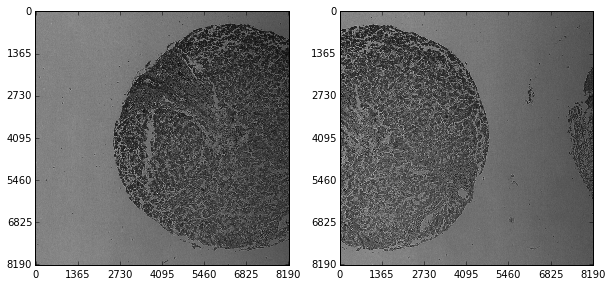

In [26]:
img1 = imread('highres1.png')
img2 = imread('highres2.png')

side_by_side(img1, img2)

In [5]:
import imreg_dft as imreg

In [6]:
translation = imreg.translation(img1, img2)
translation

(array([-2352,   -95]), 0.001307361664025833)

Negative offset? should be positive $\approx$ (0, 4500)

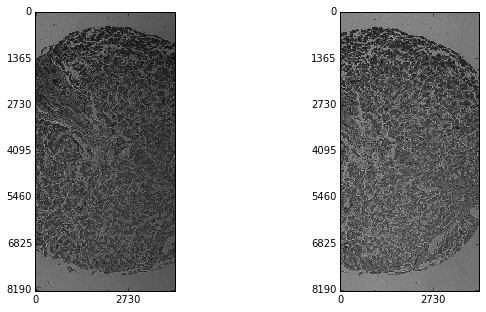

In [27]:
# try only half part of the images
y,x = img1.shape
img1 = img1[:,x//2:]
img2 = img2[:,:x//2]

side_by_side(img1, img2)

In [8]:
translation = imreg.translation(img2, img1)
translation

(array([   24, -1150]), 0.0064858760289995421)

if -1150 => 1150, then this is resonable

In [9]:
import numpy as np

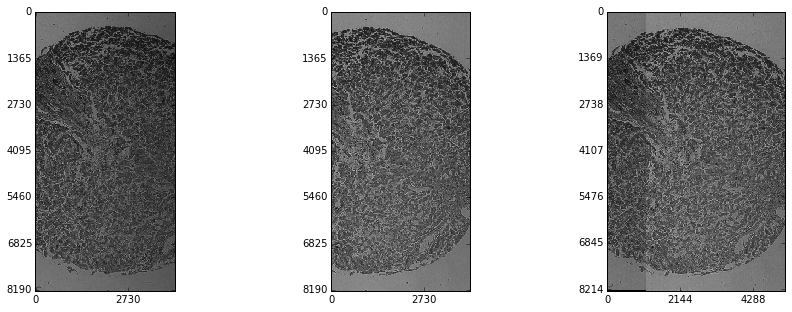

In [28]:
def stitch(img1, img2, dy, dx):
    y,x = img1.shape
    merged = np.zeros((y+dy, x+dx), dtype=img1.dtype)
    if dy == 0:
        dy = -y
    merged[:-dy, :x] = img1
    merged[dy:, dx:] = img2
    return merged

merged = stitch(img1, img2, 24, 1150)
side_by_side(img1, img2, merged)

lets see if similarity gives more clues

In [11]:
imreg.similarity(img1, img2)

/Users/arve/.virtualenvs/3.4/lib/python3.4/site-packages/scipy/ndimage/interpolation.py:549: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


{'Dangle': 0.010986328125,
 'Dscale': 0.0004885434507322713,
 'Dt': 0.5,
 'angle': -180.0,
 'scale': 0.95092283933292321,
 'success': 0.0021549694859432358,
 'timg': array([[ 108.50144587,  108.74136887,  108.63795675, ...,  106.80581961,
          107.68216762,  107.88135859],
        [ 108.63931219,  108.62707986,  108.57361162, ...,  107.99708288,
          108.42525833,  108.57956627],
        [ 108.48971195,  108.51701786,  108.53520526, ...,  107.95008323,
          108.25694933,  108.4199571 ],
        ..., 
        [ 109.49181408,  109.2869765 ,  108.75819702, ...,   78.97913048,
           91.91827304,   92.80159535],
        [ 108.61112009,  109.10976981,  108.77405794, ...,   81.18623595,
           89.44549007,   90.16867926],
        [ 108.04356269,  108.87271175,  108.71405763, ...,   83.05210836,
           89.09025164,   86.09612581]]),
 'tvec': array([2537,  993])}

hmm, angle -180

# try out lowres lena image

In [12]:
from skimage import data, color

In [13]:
lena = color.rgb2gray(data.lena())
lena.shape

(512, 512)

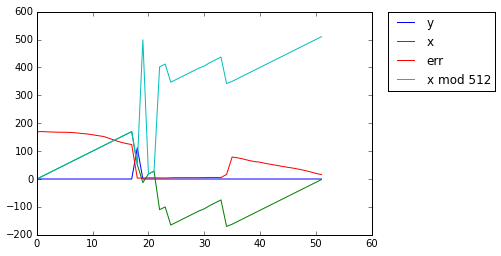

In [14]:
translations = []
for start in range(0, 512, 10):
    img1 = lena
    img2 = np.zeros_like(lena)
    end = 512-start
    img2[:, :end] = lena[:, start:]
    pos,err = imreg.translation(img1, img2)
    translations.append((pos[0], pos[1], err, pos[1]%512))

# for slice notation
translations = np.array(translations)
# scale up error (never rememeber the mpl syntax)
translations[:,2] *= max(translations[:,1])/max(translations[:,2])

plot(translations)
legend(('y', 'x', 'err', 'x mod 512'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

compare to scikit-image implementation

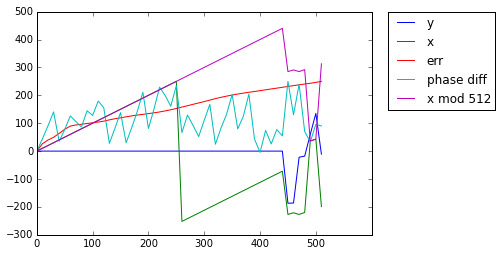

In [15]:
from skimage.feature import register_translation
translations = []
for start in range(0, 512, 10):
    img1 = lena
    img2 = np.zeros_like(lena)
    end = 512-start
    img2[:, :end] = lena[:, start:]
    pos,err,phase = register_translation(img1, img2)
    translations.append((pos[0], pos[1], err, phase, pos[1]%512))

# for slice notation
translations = np.array(translations)
# scale up error (never rememeber the mpl syntax)
translations[:,2] *= max(translations[:,1])/max(translations[:,2])
translations[:,3] *= max(translations[:,1])/max(translations[:,3])

plot(translations)
legend(('y', 'x', 'err', 'phase diff', 'x mod 512'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
xticks(range(0,512//10,10), [str(x) for x in range(0,512,100)]);

hmm, seems more reliable

# template matching

400

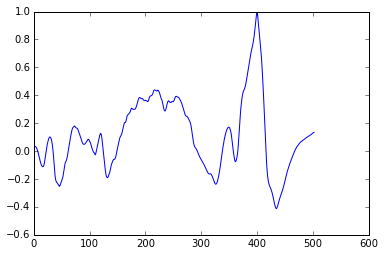

In [16]:
from skimage import feature
match = feature.match_template(lena, lena[:,400:410])
plot(match[0,:])
np.argmax(match[0,:])

In [17]:
def template_registration(img1, img2):
    "get translation by doing a template match on img1 using beginning of img2"
    match = feature.match_template(img1, img2[:,:10])
    return np.argmax(match[0,:])

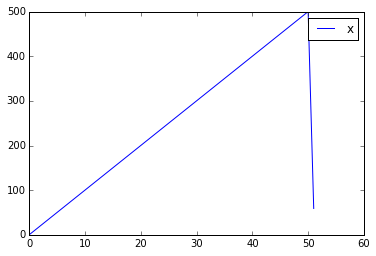

In [18]:
translations = []
for start in range(0, 512, 10):
    img1 = lena
    img2 = np.zeros_like(lena)
    end = 512-start
    img2[:, :end] = lena[:, start:]
    pos = template_registration(img1, img2)
    translations.append(pos)

plot(translations)
legend(('x'));

Seems very reliable, lets try the large image, assume positive x translation and start of img2 in last half of img2

In [19]:
def template_registration_large(img1, img2):
    "get translation by doing a template match on img1 using beginning of img2"
    y,x = img1.shape
    start = x//2
    # 8000 pixels should be enough for correlation
    rows = int(8000/img2.shape[0]+0.5)
    match = feature.match_template(img1[:,start:], img2[:,:1])
    return start + np.argmax(match[0,:])

In [30]:
img1 = imread('highres1.png')
img2 = imread('highres2.png')

In [21]:
%time template_registration_large(img1, img2)

CPU times: user 54.1 s, sys: 27.8 s, total: 1min 21s
Wall time: 1min 49s


5204

Not that speedy, eating $\approx$ 6GB memory

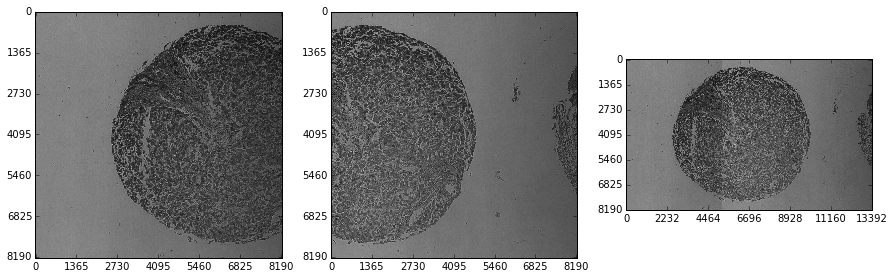

In [31]:
merged = stitch(img1, img2, 0, 5204)
side_by_side(img1, img2, merged)